In [ ]:
import os
import xarray as xr
import numpy as np

# --- Configuration ---
static_path = "/content/drive/MyDrive/Flood_Thesis/Data/static_data/static_kathmandu.nc"
output_dir_025 = "/content/drive/MyDrive/Flood_Thesis/Data/smallbox_025/static"
output_dir_01 = "/content/drive/MyDrive/Flood_Thesis/Data/smallbox_01/static"

os.makedirs(output_dir_025, exist_ok=True)
os.makedirs(output_dir_01, exist_ok=True)

# --- Load static dataset ---
ds = xr.open_dataset(static_path)
x_vals = ds.x.values
y_vals = ds.y.values

# --- Grid configs ---
def generate_grid(x_vals, y_vals, tile_size):
    min_x, max_x = x_vals.min(), x_vals.max()
    min_y, max_y = y_vals.min(), y_vals.max()
    xs = np.arange(min_x, max_x, tile_size)
    ys = np.arange(min_y, max_y, tile_size)
    return [(round(x, 5), round(y, 5)) for x in xs for y in ys]

grid_025 = generate_grid(x_vals, y_vals, 0.25)
grid_01 = generate_grid(x_vals, y_vals, 0.1)

# --- Extraction function ---
def crop_and_save(ds, grid, tile_size, output_dir, label):
    for lon, lat in grid:
        bbox = (lon, lat, lon + tile_size, lat + tile_size)
        cropped = ds.sel(x=slice(bbox[0], bbox[2]), y=slice(bbox[3], bbox[1]))
        if cropped.to_array().count().item() == 0:
            print(f"❌ Empty static crop for {bbox}")
            continue
        out_path = f"{output_dir}/static_{label}_{lat}_{lon}.nc"
        cropped.to_netcdf(out_path, engine="h5netcdf")

# --- Process both resolutions ---
crop_and_save(ds, grid_025, 0.25, output_dir_025, "025")
crop_and_save(ds, grid_01, 0.1, output_dir_01, "01")

print("✅ Finished generating static mini datacubes.")


❌ Empty static crop for (np.float64(85.15), np.float64(27.40025), np.float64(85.4), np.float64(27.65025))
❌ Empty static crop for (np.float64(85.15), np.float64(27.65025), np.float64(85.4), np.float64(27.90025))
❌ Empty static crop for (np.float64(85.4), np.float64(27.40025), np.float64(85.65), np.float64(27.65025))
❌ Empty static crop for (np.float64(85.4), np.float64(27.65025), np.float64(85.65), np.float64(27.90025))
❌ Empty static crop for (np.float64(85.15), np.float64(27.40025), np.float64(85.25), np.float64(27.50025))
❌ Empty static crop for (np.float64(85.15), np.float64(27.50025), np.float64(85.25), np.float64(27.600250000000003))
❌ Empty static crop for (np.float64(85.15), np.float64(27.60025), np.float64(85.25), np.float64(27.70025))
❌ Empty static crop for (np.float64(85.15), np.float64(27.70025), np.float64(85.25), np.float64(27.800250000000002))
❌ Empty static crop for (np.float64(85.15), np.float64(27.80025), np.float64(85.25), np.float64(27.90025))
❌ Empty static crop f

In [ ]:
print(f"Static data longitude range: {ds.x.min().item()} to {ds.x.max().item()}")
print(f"Static data latitude range: {ds.y.min().item()} to {ds.y.max().item()}")


Static data longitude range: 85.15 to 85.59975
Static data latitude range: 27.40025 to 27.85


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.3 MB/s eta 0:00:00


<ipython-input-1-d50d444c794e>:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dem_clip, dem_transform = mask(src, [valley.unary_union], crop=True)
<ipython-input-1-d50d444c794e>:38: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  water_clip, water_transform = mask(src, [valley.unary_union], crop=True)


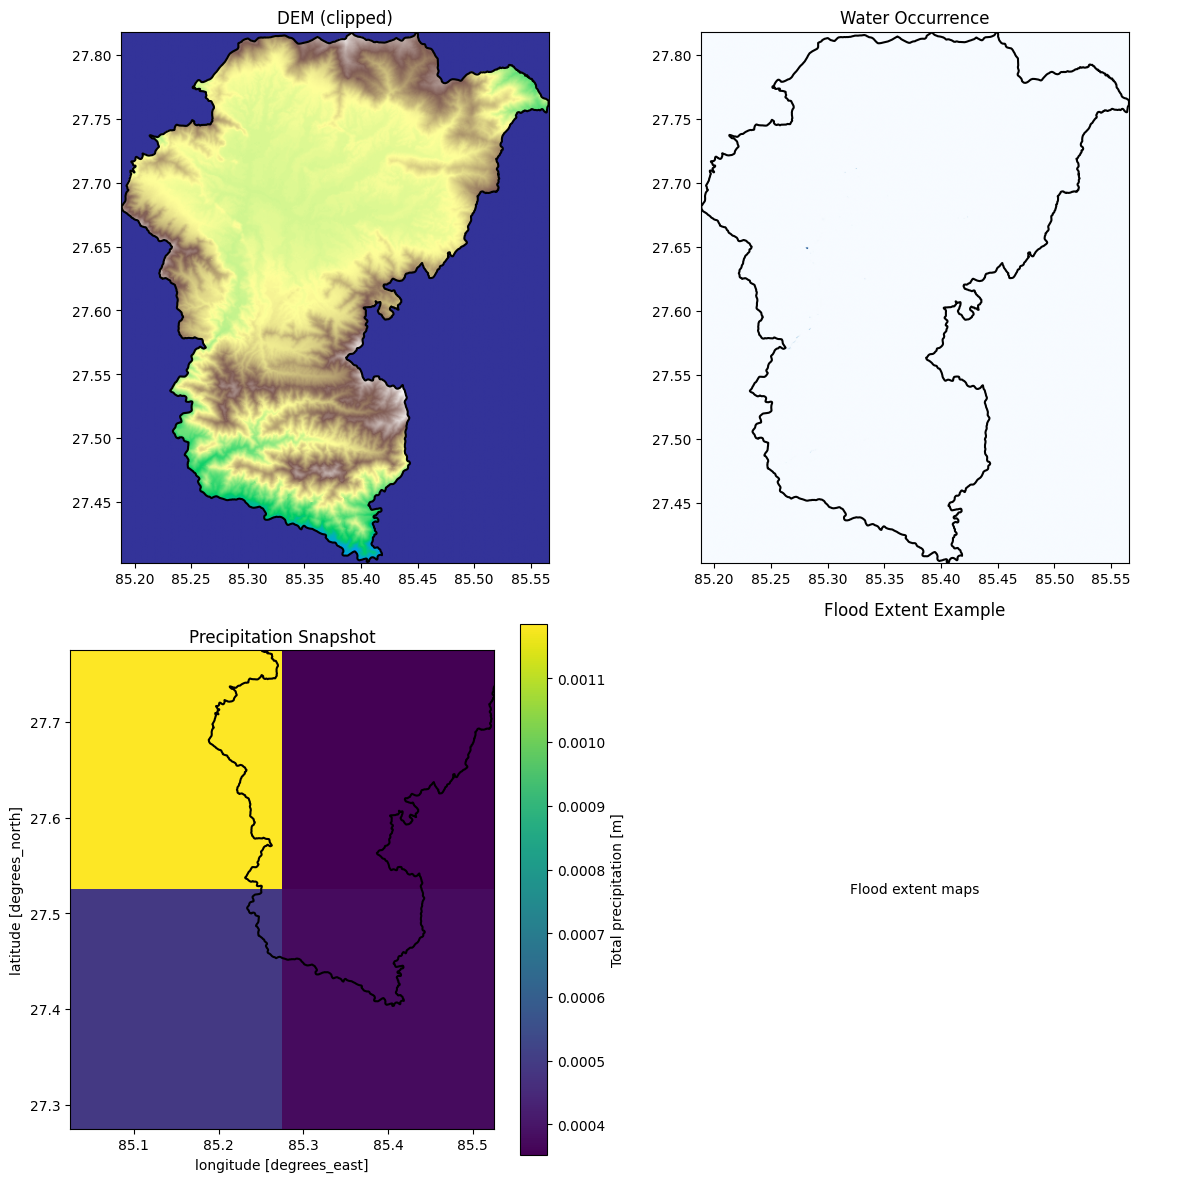

In [1]:
# 1. Mount Drive & Install
from google.colab import drive
drive.mount('/content/drive')

!pip install rasterio geopandas xarray matplotlib

# 2. Imports & Paths
import rasterio
from rasterio.mask import mask
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

dem_path   = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data/srtm-cgiar-nepal-boundary-dem-90m/srtm_cgiar_nepal_boundary.img')
water_path = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data/water_occurrence_Kathmandu.tif')
tp_path    = Path('/content/drive/MyDrive/Flood_Thesis/Data/ERA5_Data/Coarse_ERA5/tp_ERA5_2017_2019.nc')
shp_path   = Path('/content/drive/MyDrive/Flood_Thesis/Data/kathmandu valley border/kathmandu valley border.shp')

# 3. Load boundary
valley = gpd.read_file(shp_path).to_crs(epsg=4326)

# 4. Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# DEM
with rasterio.open(dem_path) as src:
    dem_clip, dem_transform = mask(src, [valley.unary_union], crop=True)
axes[0,0].imshow(dem_clip[0], cmap='terrain', extent=(dem_transform[2],
    dem_transform[2] + dem_transform[0]*dem_clip.shape[2],
    dem_transform[5] + dem_transform[4]*dem_clip.shape[1],
    dem_transform[5]))
valley.boundary.plot(ax=axes[0,0], edgecolor='black')
axes[0,0].set_title('DEM (clipped)')

# Water Occurrence
with rasterio.open(water_path) as src:
    water_clip, water_transform = mask(src, [valley.unary_union], crop=True)
axes[0,1].imshow(water_clip[0], cmap='Blues', extent=(water_transform[2],
    water_transform[2] + water_transform[0]*water_clip.shape[2],
    water_transform[5] + water_transform[4]*water_clip.shape[1],
    water_transform[5]))
valley.boundary.plot(ax=axes[0,1], edgecolor='black')
axes[0,1].set_title('Water Occurrence')

# Precipitation snapshot
ds_tp = xr.open_dataset(tp_path, engine='h5netcdf').rename({'valid_time':'time'})
da_tp = ds_tp['tp'].isel(time=196)  # e.g. the 197th timestep (around 2017-07-15)
da_tp.plot(ax=axes[1,0], cmap='viridis')
valley.boundary.plot(ax=axes[1,0], edgecolor='black')
axes[1,0].set_title('Precipitation Snapshot')

# Flood extent placeholder
axes[1,1].axis('off')
axes[1,1].text(0.5, 0.5, 'Flood extent maps', ha='center', va='center')
axes[1,1].set_title('Flood Extent Example')

plt.tight_layout()
plt.show()


=== Static Feature Summary ===
       mean_slope  max_slope  std_slope  dist_to_river_m
count   25.000000  25.000000  25.000000        25.000000
mean     7.922335  58.236800  10.173838      4403.850636
std      7.384116  39.229155   7.997996      4446.261811
min      0.000000   0.000000   0.000000        60.488264
25%      0.000000   0.000000   0.000000       549.938190
50%      7.487419  83.912796  13.815958      2283.543447
75%     13.336881  87.094795  16.241796      8383.168319
max     28.214570  88.066890  24.218895     13065.235073


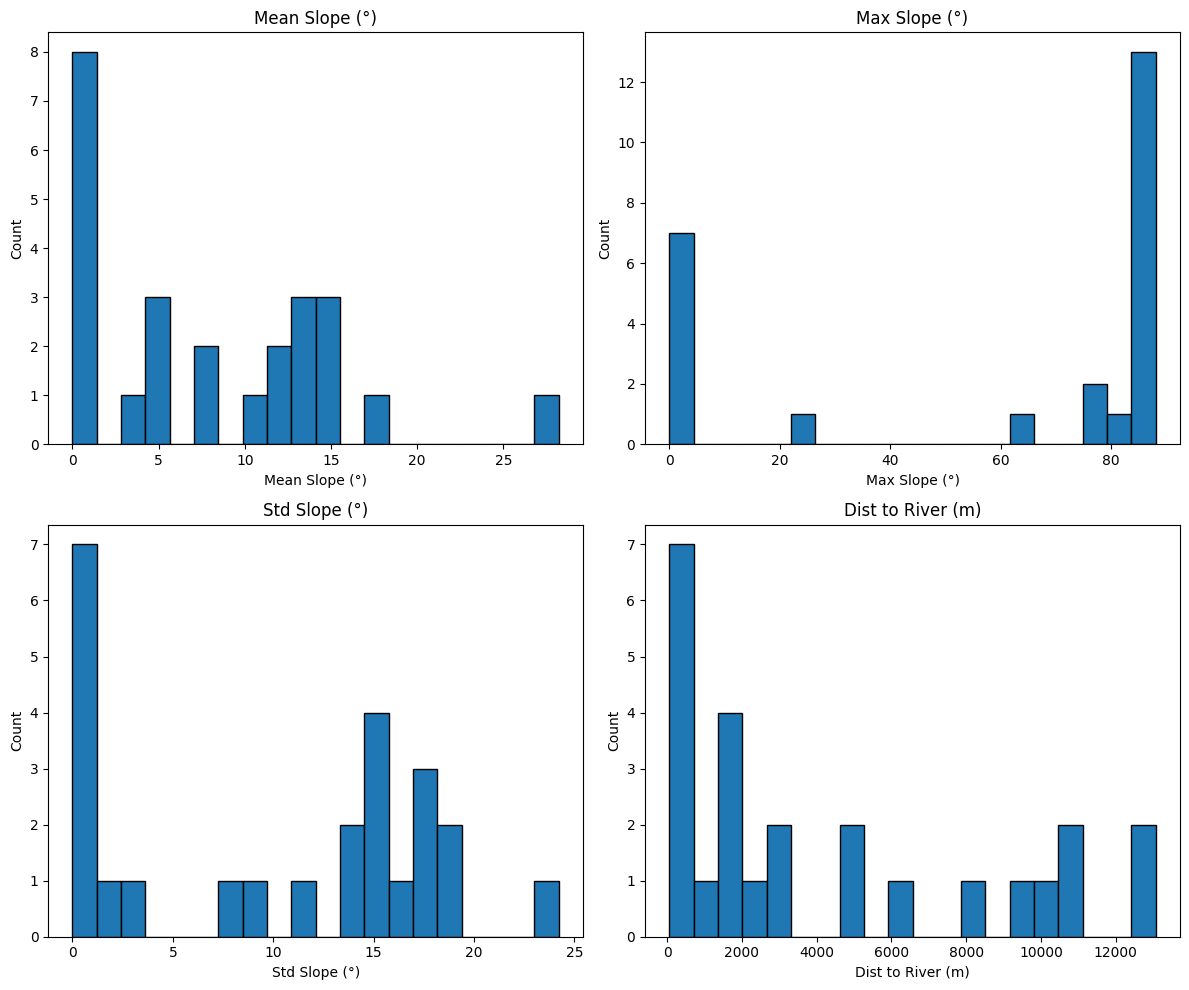

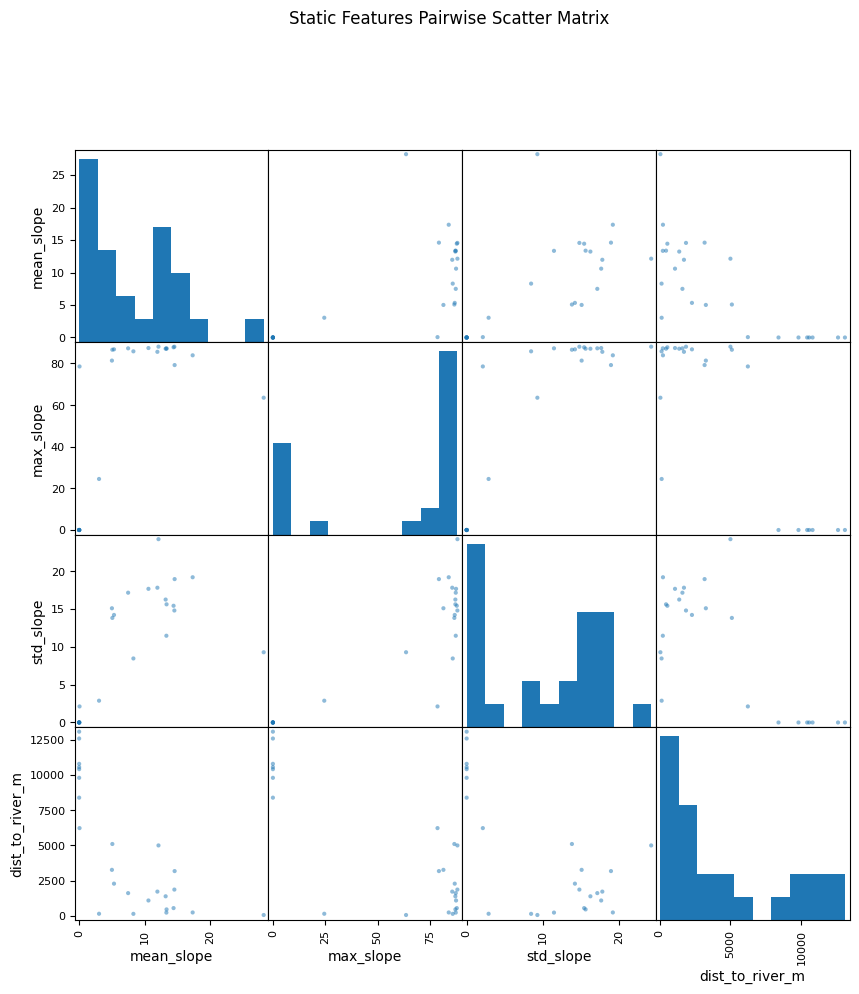

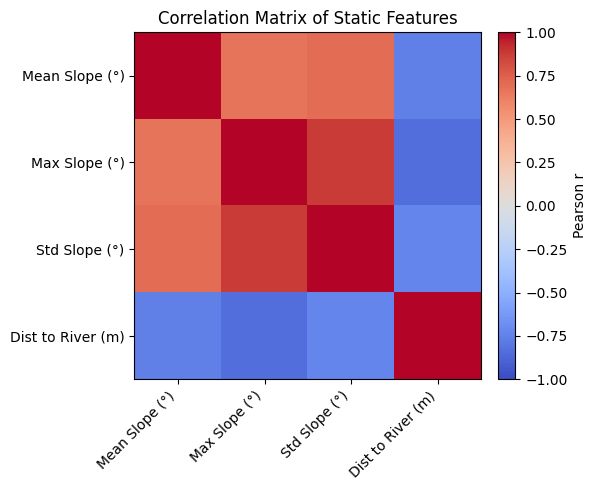

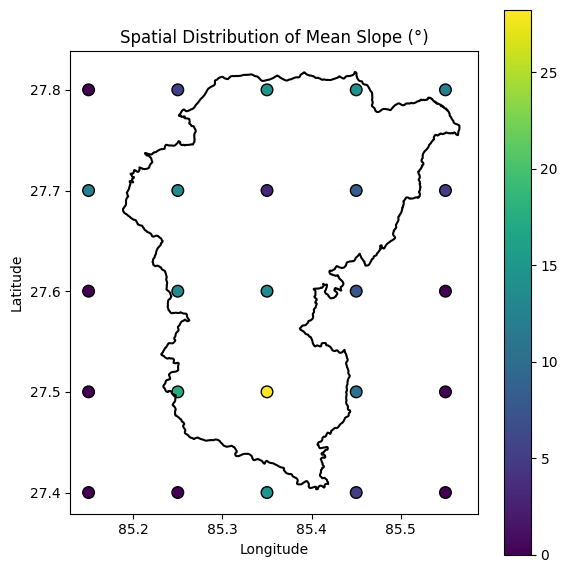

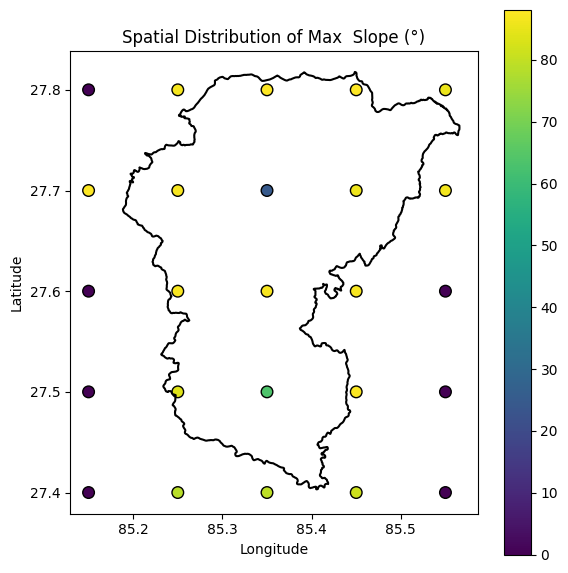

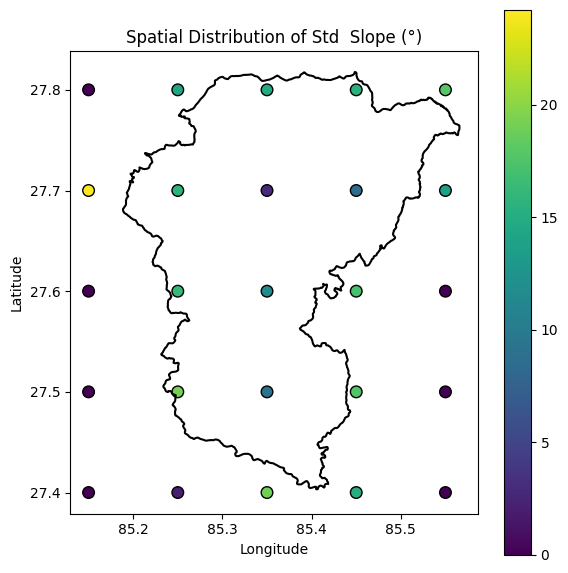

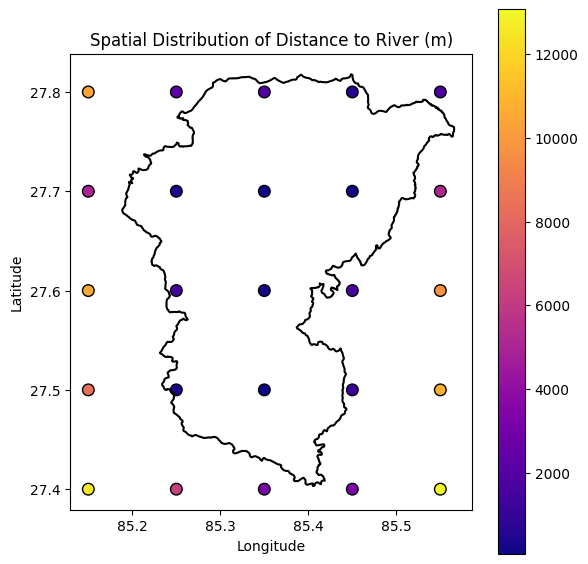

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pathlib import Path

# 1) Load your static CSVs (update these paths as needed)
SLOPE_CSV = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data/slope_0.1deg.csv')
RIVER_CSV = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data/dist_to_river_0.1deg.csv')

slope_df = pd.read_csv(SLOPE_CSV)
river_df = pd.read_csv(RIVER_CSV)
static_df = slope_df.merge(river_df, on=['lat_center','lon_center'])

# 2) Summary statistics
print("=== Static Feature Summary ===")
print(static_df[['mean_slope','max_slope','std_slope','dist_to_river_m']].describe())

# 3) Histograms of each feature
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
cols  = ['mean_slope','max_slope','std_slope','dist_to_river_m']
titles= ['Mean Slope (°)','Max Slope (°)','Std Slope (°)','Dist to River (m)']
for ax, col, title in zip(axes, cols, titles):
    ax.hist(static_df[col], bins=20, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel(title)
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

# 4) Pairwise scatter matrix
pd.plotting.scatter_matrix(
    static_df[cols],
    figsize=(10, 10),
    diagonal='hist'
)
plt.suptitle("Static Features Pairwise Scatter Matrix", y=1.02)
plt.show()

# 5) Correlation heatmap
corr = static_df[cols].corr()
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr, vmin=-1, vmax=1, cmap='coolwarm')
ax.set_xticks(range(len(cols)))
ax.set_yticks(range(len(cols)))
ax.set_xticklabels(titles, rotation=45, ha='right')
ax.set_yticklabels(titles)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Pearson r")
ax.set_title("Correlation Matrix of Static Features")
plt.tight_layout()
plt.show()

# 6) Spatial distribution maps
# Load your Kathmandu border shapefile
SHAPEFILE = Path('/content/drive/MyDrive/Flood_Thesis/Data/kathmandu valley border/kathmandu valley border.shp')
valley    = gpd.read_file(SHAPEFILE).to_crs(epsg=4326)

# Create GeoDataFrame of tile centers
gdf = gpd.GeoDataFrame(
    static_df,
    geometry=[Point(lon, lat)
              for lon, lat in zip(static_df.lon_center, static_df.lat_center)],
    crs='EPSG:4326'
)

# Plot each static variable
for col, title, cmap in [
    ('mean_slope',      'Mean Slope (°)','viridis'),
    ('max_slope',       'Max  Slope (°)','viridis'),
    ('std_slope',       'Std  Slope (°)','viridis'),
    ('dist_to_river_m', 'Distance to River (m)','plasma')
]:
    fig, ax = plt.subplots(figsize=(6, 6))
    valley.boundary.plot(ax=ax, edgecolor='black')
    gdf.plot(
        ax=ax,
        column=col,
        cmap=cmap,
        legend=True,
        markersize=70,
        edgecolor='k'
    )
    ax.set_title(f"Spatial Distribution of {title}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.tight_layout()
    plt.show()
